## GCN

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from data.featurization.dgl_Graph import DGL_Graph
from model.dgl.GCN import GCN
from sklearn.metrics import root_mean_squared_error, r2_score, cohen_kappa_score
from sklearn.model_selection import KFold
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from collections import defaultdict

In [2]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

### Regression Problems

In [ ]:
trn = pd.read_csv("../data/trn.reg.csv.gz", compression='gzip', low_memory=False)
tst = pd.read_csv("../data/tst.reg.csv.gz", compression='gzip', low_memory=False)

trn_X = trn["SMILES"]
tst_X = tst["SMILES"]
trn_y = trn["LogS"]
tst_y = tst["LogS"]

In [4]:
featurizer = DGL_Graph(
    graph_type="BI_GRAPH",
    featurize_type="Canonical",
    self_loop=True
)
trn_X = featurizer.convert(trn_X)
tst_X = featurizer.convert(tst_X)

Hyper-parameter Tuning.

In [7]:
tune_space = {
    "hidden_feats": hp.choice("hidden_feats",
                              [[64], [64, 64], [128, 64], [256, 128, 64],
                               [128, 128, 64], [256, 128, 128]]),
    "gnn_norm": hp.choice("gnn_norm", ['right', 'both', 'none']),
    "residual": hp.choice("residual", [True, False]),
    "batchnorm": hp.choice("batchnorm", [True, False]),
    "dropout": hp.uniform("dropout", 0, 1),
    "lr": hp.choice("lr", [0.1, 0.01, 0.001]),
    "weight_decay": hp.uniform("weight_decay", 0, 1),

    "batch_size": 128,
}

In [6]:
def tune_obj(space):
    kf = KFold(n_splits=5, shuffle=True)
    rmse = []

    for trn_idx, val_idx in kf.split(trn_X):
        tX, vX = trn_X[trn_idx], trn_X[val_idx]
        ty, vy = trn_y[trn_idx], trn_y[val_idx]

        model = GCN(
            n_tasks=1,
            in_feats=featurizer.get_node_feat_size(),
            hidden_feats=space["hidden_feats"],
            gnn_norm=space["gnn_norm"],
            activation=torch.nn.functional.relu,
            residual=space["residual"],
            batchnorm=space["batchnorm"],
            dropout=space["dropout"],
            classifier_hidden_feats=128,
            classifier_dropout=0,
            predictor_hidden_feats=128,
            predictor_dropout=0,
            lr=space["lr"],
            weight_decay=space["weight_decay"],
            batch_size=128
        )

        scores = model.fit(tX, ty,
                           val_X=vX, val_y=vy,
                           epochs=800, min_epochs=500, early_stop_epochs=20, verbose=False)
        rmse.append(scores["rmse"][-1])

    return {"loss": np.mean(rmse), 'status': STATUS_OK}

In [ ]:
trials = Trials()
best_params = fmin(
    fn=tune_obj,
    space=tune_space,
    algo=tpe.suggest,
    max_evals=500,
    trials=trials
)

In [ ]:
best_params

In [16]:
best_params = {
    "hidden_feats": [256, 128, 64],
    "gnn_norm": 'both',
    "residual": True,
    "batchnorm": True,
    "dropout": 0.07075484753350235,
    "lr": 0.001,
    "weight_decay": 0.003975036016795143,
    "batch_size": 128,
}

K-fold CV.

In [6]:
def k_fold_CV(n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True)
    rmse, r2 = [], []

    for trn_idx, val_idx in kf.split(trn_X):
        tX, vX = trn_X[trn_idx], trn_X[val_idx]
        ty, vy = trn_y[trn_idx], trn_y[val_idx]

        model = GCN(
            n_tasks=1,
            in_feats=featurizer.get_node_feat_size(),
            hidden_feats=best_params["hidden_feats"],
            gnn_norm=best_params["gnn_norm"],
            activation=torch.nn.functional.relu,
            residual=best_params["residual"],
            batchnorm=best_params["batchnorm"],
            dropout=best_params["dropout"],
            classifier_hidden_feats=128,
            classifier_dropout=0,
            predictor_hidden_feats=128,
            predictor_dropout=0,
            lr=best_params["lr"],
            weight_decay=best_params["weight_decay"],
            batch_size=128
        )
        model.fit(tX, ty, val_X=vX, val_y=vy, epochs=400)
        pred_val = model.predict(vX).cpu()

        rmse.append(root_mean_squared_error(vy, pred_val))
        r2.append(r2_score(vy, pred_val))

    return pd.DataFrame({"rmse": rmse, "r2": r2})

In [ ]:
pd.concat([k_fold_CV() for _ in range(10)])

Prediction and estimation.

In [10]:
def predict():
    kf = KFold(n_splits=5, shuffle=True)
    prediction = []

    for trn_idx, val_idx in kf.split(trn_X):
        tX, vX = trn_X[trn_idx], trn_X[val_idx]
        ty, vy = trn_y[trn_idx], trn_y[val_idx]

        model = GCN(
            n_tasks=1,
            in_feats=featurizer.get_node_feat_size(),
            hidden_feats=best_params["hidden_feats"],
            gnn_norm=best_params["gnn_norm"],
            activation=torch.nn.functional.relu,
            residual=best_params["residual"],
            batchnorm=best_params["batchnorm"],
            dropout=best_params["dropout"],
            classifier_hidden_feats=128,
            classifier_dropout=0,
            predictor_hidden_feats=128,
            predictor_dropout=0,
            lr=best_params["lr"],
            weight_decay=best_params["weight_decay"],
            batch_size=128,
        )
        model.fit(tX, ty, val_X=vX, val_y=vy, epochs=800, min_epochs=400, early_stop_epochs=20)
        prediction.append(model.predict(tst_X))

    return [torch.mean(pred_i).item() for pred_i in torch.cat(prediction, 1)]

In [ ]:
preds = [predict() for _ in range(50)]
preds = pd.concat([pd.Series(p) for p in preds], axis=1)

In [12]:
rmse, r2 = defaultdict(list), defaultdict(list)

for pred in [preds[c] for c in preds.columns]:
    df = pd.DataFrame({"pred": pred, "set": tst["set"], "true": tst["LogS"]})
    for s in df["set"].unique():
        p = df[df["set"] == s]
        rmse[s].append(root_mean_squared_error(p["true"], p["pred"]))
        r2[s].append(r2_score(p["true"], p["pred"]))

In [13]:
for s in rmse.keys():
    print(f"[{s}] rmse:{np.mean(rmse[s]):.2f}±{np.std(rmse[s]):.2f} r2:{np.mean(r2[s]):.2f}±{np.std(r2[s]):.2f}")

[2008SC Test Set] rmse:0.87±0.00 r2:0.59±0.00
[2019SC Testset 1] rmse:0.73±0.00 r2:0.56±0.00
[2019SC Testset 2] rmse:1.70±0.00 r2:0.28±0.00


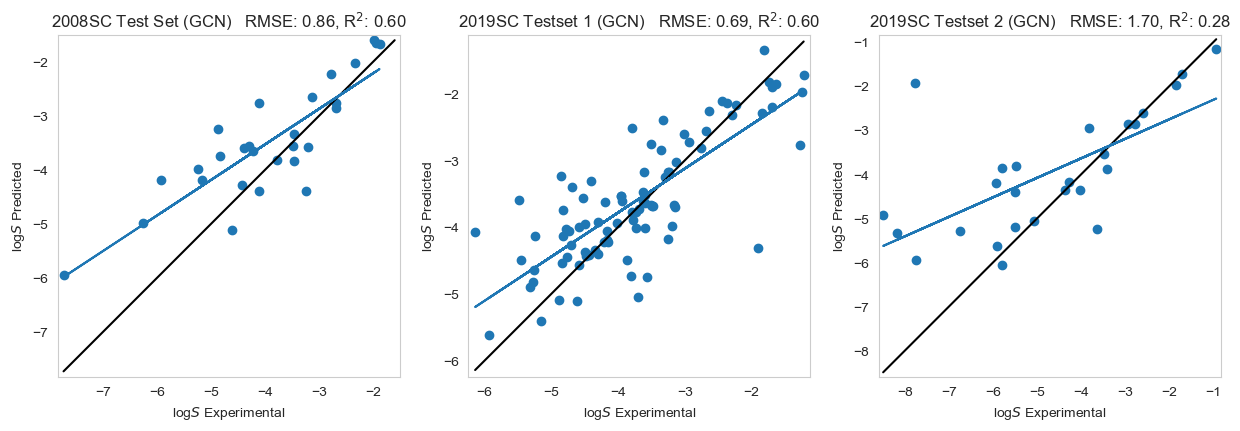

In [24]:
def subplot(x, y, ax):
    ax.scatter(x, y)
    ax.set_xlim((min(min(x), min(y)) - 0.1, max(max(x), max(y)) + 0.1))
    ax.set_ylim((min(min(x), min(y)) - 0.1, max(max(x), max(y)) + 0.1))
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect(abs(x1 - x0) / abs(y1 - y0))
    ax.grid(which='major', linestyle='--')
    ax.plot([min(min(x), min(y)), max(max(x), max(y))], [min(min(x), min(y)), max(max(x), max(y))], 'k')
    a, b = np.polyfit(x, y, 1)
    y_fit = a * x + b
    ax.plot(x, y_fit)
    ax.set_xlabel("log$S$ Experimental")
    ax.set_ylabel("log$S$ Predicted")


model_name = "GCN"
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(5 * 3, 5))
df = pd.DataFrame({"pred": preds.iloc[:, np.argmin(np.array(list(rmse.values())).mean(axis=0))],
                   "set": tst["set"], "true": tst["LogS"]})
for s, ax in zip(rmse.keys(), axs):
    idx = tst[tst["set"] == s].index
    t = df["true"].loc[idx]
    p = df["pred"].loc[idx]
    subplot(t, p, ax)
    ax.grid(False)
    ax.set_title(f"{s} ({model_name})   "
                 f"RMSE: {root_mean_squared_error(t, p):.2f}, "
                 f"R$^2$: {r2_score(t, p):.2f}")

## Classification Problem

In [3]:
trn = pd.concat([pd.read_csv(f"../data/trn.EUOS-SLAS.Part{i}.csv.gz") for i in range(1, 9)])
tst = pd.concat([pd.read_csv(f"../data/tst.EUOS-SLAS.Part{i}.csv.gz") for i in range(1, 5)])

trn_X = trn["SMILES"]
tst_X = tst["SMILES"]
trn_y = trn["solubility"]

In [4]:
featurizer = DGL_Graph(
    graph_type="BI_GRAPH",
    featurize_type="Canonical",
    self_loop=True
)
trn_X = featurizer.convert(trn_X)
tst_X = featurizer.convert(tst_X)

Hyper-parameter Tuning.

In [11]:
def tune_obj(space):
    kf = KFold(n_splits=5, shuffle=True)
    qck = []

    for trn_idx, val_idx in kf.split(trn_X):
        tX, vX = trn_X[trn_idx], trn_X[val_idx]
        ty, vy = trn_y[trn_idx], trn_y[val_idx]

        model = GCN(
            n_tasks=3,
            in_feats=featurizer.get_node_feat_size(),
            hidden_feats=space["hidden_feats"],
            gnn_norm=space["gnn_norm"],
            activation=torch.nn.functional.relu,
            residual=space["residual"],
            batchnorm=space["batchnorm"],
            dropout=space["dropout"],
            classifier_hidden_feats=128,
            classifier_dropout=0,
            predictor_hidden_feats=128,
            predictor_dropout=0,
            lr=space["lr"],
            weight_decay=space["weight_decay"],
            batch_size=128,
        )
        scores = model.fit(tX, ty,
                           val_X=vX, val_y=vy,
                           epochs=800, min_epochs=500, early_stop_epochs=10, verbose=False)
        qck.append(scores["qck"][-1])

    return {"loss": np.mean(qck), 'status': STATUS_OK}

In [ ]:
trials = Trials()
best_params = fmin(
    fn=tune_obj,
    space=tune_space,
    algo=tpe.suggest,
    max_evals=500,
    trials=trials
)

In [ ]:
best_params

K-fold CV.

In [14]:
def k_fold_CV(n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True)
    qck = []

    for trn_idx, val_idx in kf.split(trn_X):
        tX, vX = trn_X[trn_idx], trn_X[val_idx]
        ty, vy = trn_y[trn_idx], trn_y[val_idx]

        model = GCN(
            n_tasks=3,
            in_feats=featurizer.get_node_feat_size(),
            hidden_feats=best_params["hidden_feats"],
            gnn_norm=best_params["gnn_norm"],
            activation=torch.nn.functional.relu,
            residual=best_params["residual"],
            batchnorm=best_params["batchnorm"],
            dropout=best_params["dropout"],
            classifier_hidden_feats=128,
            classifier_dropout=0,
            predictor_hidden_feats=128,
            predictor_dropout=0,
            lr=best_params["lr"],
            weight_decay=best_params["weight_decay"],
            batch_size=128
        )
        model.fit(tX, ty, val_X=vX, val_y=vy, epochs=400)
        pred_val = model.predict(vX).cpu()
        pred_val = torch.argmax(pred_val, dim=1)

        qck.append(cohen_kappa_score(vy, pred_val, weights="quadratic"))

    return pd.DataFrame({"qck": qck})

In [ ]:
pd.concat([k_fold_CV() for _ in range(10)])

Prediction and estimation.

In [19]:
def predict():
    kf = KFold(n_splits=5, shuffle=True)
    prediction = []

    for trn_idx, val_idx in kf.split(trn_X):
        tX, vX = trn_X[trn_idx], trn_X[val_idx]
        ty, vy = trn_y[trn_idx], trn_y[val_idx]

        model = GCN(
            n_tasks=3,
            in_feats=featurizer.get_node_feat_size(),
            hidden_feats=best_params["hidden_feats"],
            gnn_norm=best_params["gnn_norm"],
            activation=torch.nn.functional.relu,
            residual=best_params["residual"],
            batchnorm=best_params["batchnorm"],
            dropout=best_params["dropout"],
            classifier_hidden_feats=128,
            classifier_dropout=0,
            predictor_hidden_feats=128,
            predictor_dropout=0,
            lr=best_params["lr"],
            weight_decay=best_params["weight_decay"],
            batch_size=128,
        )
        model.fit(tX, ty, val_X=vX, val_y=vy, epochs=800, min_epochs=400, early_stop_epochs=20)
        prediction.append(model.predict(tst_X))

    return torch.argmax(torch.stack(prediction).mean(dim=0), dim=1).cpu()

In [ ]:
preds = [predict() for _ in range(50)]
preds = pd.DataFrame([p.numpy().tolist() for p in preds]).transpose()
preds

Upload the predictions to the challenge to get feedback on the model's performance.